# Bayesian Fit to a Known True Value

In this notebook Bayesian and Least Squares fitting is applied to a simulated dataset which was created using a known stress state, in order to compare the fit to a 'true' distribution. The dataset will be adjusted in sample size, error distribution and the presence of extreme outliers, with the aim of assessing how Bayesian performs comparing to Least Squares in different situations. 

<br> Part 1: Simulating a Dataset Based on a Known Stress State
<br> Part 2: Fitting the Strain using Ordinary Least Squares Regression (OLS)
<br> Part 3: Fitting the Strain using Bayesian Regression
<br> Part 4: Exploring How Changes to the Dataset Impact Least and Bayesian Regressions

## Part 1: Simulating a Dataset Based on a Known Stress State

The following biaxial stress state was used as an example. Because X-Rays have limited penetration, $\sigma_{33}$ is considered to be 0 as it is normal to the sample and most stresses measured by X-Ray Diffraction are biaxial.

$$   \sigma_{ij} / MPa  =\begin{bmatrix} \sigma_{11} & \sigma_{12} & \sigma_{13} \\ \sigma_{21} & \sigma_{22} & \sigma_{23} \\ \sigma_{31} & \sigma_{32} & \sigma_{33} \end{bmatrix}   =\begin{bmatrix} 150 & 30 & 0 \\ 30 & 50 & 0 \\ 0 & 0 & 0 \end{bmatrix}$$

By treating this stress tensor as belonging to an isotropic ferritic steel, the macroscopic Young's Modulus $E$ and Poisson Ratio $\nu$ were taken as:
$$E = 210000 \ MPa $$
$$\nu = 0.28 $$


In [ ]:
%matplotlib inline

import pymc3 as pm
from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import seaborn
seaborn.set_style('white')
seaborn.set_context('notebook')

At equilibrium, shear stress components obey the conditions

$$\sigma_{12} = \sigma_{21}, \sigma_{23} = \sigma_{32} \ and \ \sigma_{13} = \sigma_{31}$$

Therefore the stress state of a material at equilibrium can be described using only 6 stress tensor components.

The fundamental stress-strain equation for 2D X-Ray Diffraction is a linear equation

$$ \epsilon = p_{11}\sigma_{11} + p_{22}\sigma_{22} + p_{33}\sigma_{33} + p_{12}\sigma_{12} + p_{23}\sigma_{23} + p_{13}\sigma_{13} $$ 

Where $\epsilon$ is the strain (dependant variable), $\sigma_{ij}$ are stress tensor components (independant variables) and $p_{ij}$ are stress coefficients. The coefficients vary based on the sample orientation in space, macroscopic properties of the sample, and if the stress tensor component represents shear or normal stress.
   
$$p_{ii} = \frac{1}{E} (1 + \nu) h_{i}^2 - \nu $$

$$p_{ij} = \frac{2}{E} (1 + \nu) h_{i} h_{j}$$

Where $\bf{h}$ is the scattering vector, described by 

$$ℎ_{1}=\sin\theta(\sin\phi\sin\psi\sin\omega+\cos\phi\cos\omega)+\cos\theta\cos\gamma\sin\phi\cos\psi−\cos\theta\sin\gamma(\sin\phi\sin\psi\cos\omega−\cos\phi\sin\omega)$$
$$ℎ_{2}=−\sin\theta(\cos\phi\sin\psi\sin\omega−\sin\phi\cos\omega)−\cos\theta\cos\gamma\cos\phi\cos\psi+\cos\theta\sin\gamma(\cos\phi\sin\psi\cos\omega+\sin\phi\sin\omega)$$
$$ℎ_{3}=\sin\theta\cos\psi\sin\omega−\cos\theta\sin\omega\cos\psi\cos\omega−\cos\theta\cos\gamma\sin\psi$$


$$ℎ_{1}=\cos𝛾$$
$$ℎ_{2}=\sin𝛾$$
$$ℎ_{3}=0$$

In [2]:
# Tuneable things
E = 210000 #for Ferritic Steel , MPa
v = 0.28
angular_range = 2*np.pi
number_of_angles = 24 # number of measurements
true_s11 = 150
true_s22 = 50
true_s12 = 30


true_strain_gamma = np.arange(0, angular_range , angular_range / 360)
gamma = np.arange(0, angular_range , angular_range / number_of_angles)
print('Data points have the following detector angles :\n', np.rad2deg(gamma))

Data points have the following detector angles :
 [  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165. 180. 195.
 210. 225. 240. 255. 270. 285. 300. 315. 330. 345.]


In [4]:
# calculating the scattering vector
def calculate_directions(gamma):
    h1 = np.cos(gamma)
    h2 = np.sin(gamma)
    h3 = np.zeros_like(h1)
    h  = np.vstack([h1, h2, h3])
    return h

#calculating stress coefficient using scattering vector
def calculate_stress_factors(h , E, v, components = '11,22,12'):
    components = [[int(c) for c in comp] for comp in components.split(',')]
    p = np.zeros_like(h)
    for row, (i,j) in enumerate(components):
        p[row] = (1+v)*h[i-1]*h[j-1]
        if i == j:
            p[row] -= v
        else:
            p[row] *= 2
        p[row] *= (1./E)
    return p

In [5]:
h = calculate_directions(gamma)
p = calculate_stress_factors(h, E, v)

true_h = calculate_directions(true_strain_gamma)
true_p = calculate_stress_factors(true_h, E, v)

#true_strain = np.dot(p.T , [true_s11, true_s22, true_s12])
true_strain= true_p[0]*true_s11  + true_p[1]*true_s22 + true_p[2]*true_s12 

strain_sample = p[0]*true_s11  + p[1]*true_s22 + p[2]*true_s12 
simulated_strain_measurements = strain_sample + np.random.normal(scale = 0.0001 ,size = strain_sample.size)

The true strain distribution is a linear sum of stress tensor components scaled by the sample co-ordinates, which simplify to $\gamma$ as described above. The result is an oscilating function, plotted below. 

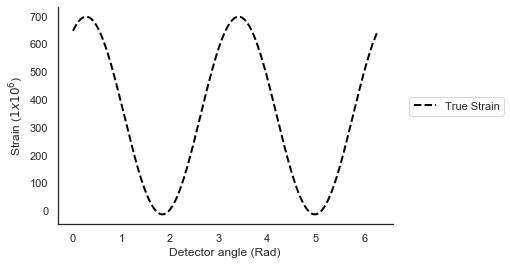

In [6]:
f, ax = plt.subplots()

ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()

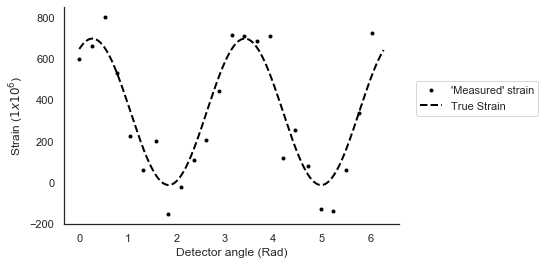

In [7]:
# plotting the 'measured' strain against gamma and the true strain

f, ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label = '\'Measured\' strain', ms = 3, color = 'k')
ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector Angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()

## Part 2: Fitting the Strain using Ordinary Least Squares Regression (OLS)

In [8]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

model = sm.OLS(simulated_strain_measurements,p.T)
fit_outcome = model.fit()





                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     77.79
Date:                Mon, 03 Aug 2020   Prob (F-statistic):           1.95e-10
Time:                        21:06:17   Log-Likelihood:                 185.27
No. Observations:                  24   AIC:                            -364.5
Df Residuals:                      21   BIC:                            -361.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           151.6173      8.739     17.349      0.0

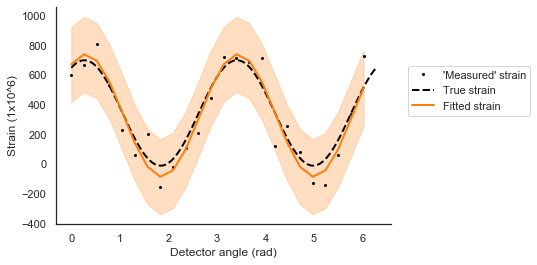

In [9]:
ols_fitted_strain = fit_outcome.predict()
prstd, iv_l, iv_u = wls_prediction_std(fit_outcome)

f,ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label='\'Measured\' strain',ms=2,color='k')
ax.plot(true_strain_gamma, true_strain*1e6, label='True strain', lw=2.,ls='--',color='k')
ax.plot(gamma, ols_fitted_strain*1e6,label='Fitted strain',lw=2,color='C1')
ax.fill_between(gamma,iv_l*1e6,iv_u*1e6,color='C1',alpha=0.25)
ax.set_xlabel('Detector angle (rad)')
ax.set_ylabel('Strain (1x10^6)')
ax.legend(loc=(1.05,0.5))
seaborn.despine()

The shading represents a confidence Interval, bearing in mind the scale (10^-6) the Least Squares fitting provides a distribution that is very close to the true strain.

## Part 3: Fitting the Strain using Bayesian Regression

When analysed using a bayesian approach, instead of being a single value, the strain can be treated as a probability distribution, assumed to be Normal thus far. Subsequently, each of the independent variables are also assumed to be Normal distributions about a mean value.

$$ ε ∼ N(p_{ij}σ_{ij} , var^2)$$

Where $var^2$ is the variance, usually referred to as $σ^2$ but adjusted here for clarity. 

In [10]:
with pm.Model() as model: 
    
    stress = pm.Normal('stress', 100, sigma = 300, shape = 3)
    sigma = pm.HalfNormal('sigma', sigma = 0.1)

    likelihood = pm.Normal('strain', 
                        mu = p[0]*stress[0]+p[1]*stress[1]+p[2]*stress[2],
                        sigma = sigma,
                        observed = simulated_strain_measurements)
    
    trace = pm.sample(draws = 1000, tune = 1000, cores = 2)
    # sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, stress]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 111 seconds.


C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
stress[0],151.251,9.269,133.628,168.043,0.216,0.153,1846.0,1846.0,1867.0,1336.0,1.0
stress[1],38.183,9.411,20.121,55.081,0.197,0.142,2273.0,2182.0,2265.0,1272.0,1.0
stress[2],37.645,5.875,26.763,49.015,0.126,0.091,2173.0,2076.0,2212.0,1504.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.000,1259.0,1155.0,1347.0,1281.0,1.0


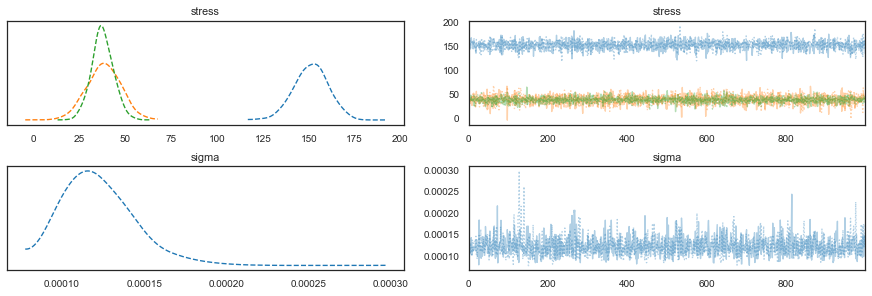

In [11]:
pm.traceplot(trace, combined = True);
pm.summary(trace)

A fit of 3 normal distributions centered close to the correct stress tensor components was obtained. Plotting the Least Squares and Bayesian fit side by side:

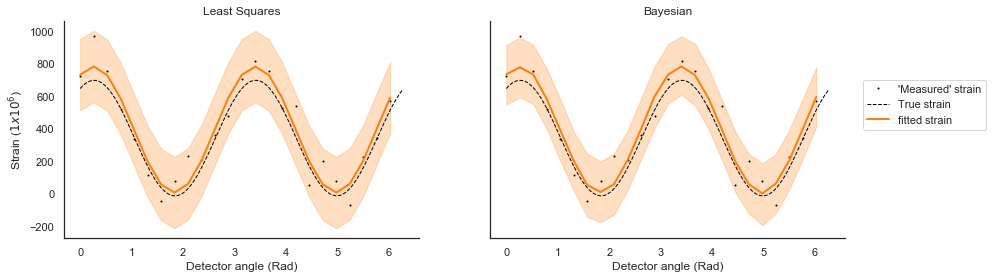

In [11]:
pymc_fitted_strain = posterior_predictive['strain'].mean(axis = 0)
lower, upper = st.mstats.mquantiles(posterior_predictive['strain'], [0.05, 0.95], axis = 0)

f, axs = plt.subplots(1, 2, figsize = (14,4), sharey = True)

for ax in axs:
    ax.plot(gamma, simulated_strain_measurements*1e6, '.', label = '\'Measured\' strain', ms = 2, color = 'k')
    ax.plot(true_strain_gamma, true_strain*1e6, '--', label = 'True strain', lw = 1., color = 'k')
    
    ax.set_xlabel('Detector angle (Rad)')

axs[0].plot(gamma,ols_fitted_strain*1e6,label='fitted strain',lw=2,color='C1')
axs[0].fill_between(gamma,iv_l*1e6,iv_u*1e6,color='C1',alpha=0.25)

#axs[1].errorbar(gamma,mean*1e6,std*1e6,fmt='_',ms=5,color='C2',label='predictions',alpha=0.5)

axs[1].plot(gamma,pymc_fitted_strain*1e6,label='fitted strain',lw=2,color='C1')
axs[1].fill_between(gamma,lower*1e6,upper*1e6,color='C1',alpha=0.25)

axs[0].set_title('Least Squares')
axs[0].set_ylabel('Strain ($1x10^6$)')
axs[1].set_title('Bayesian')
axs[1].legend(loc=(1.05, 0.5))
seaborn.despine()


The two fitting methods show almost identiacal results. Histograms were made to compare the distributions of the stress tensor predictions by both models. For OLS, 2000 samples were plotted to create a 'fit distribution' but in reality OLS returns a single value with an error. 

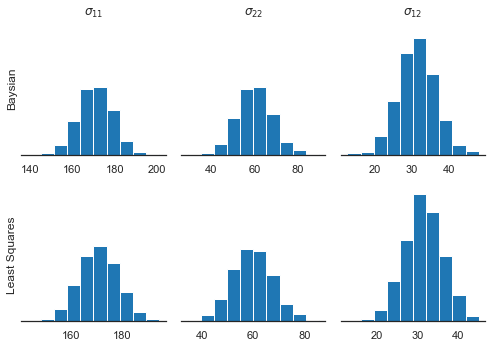

In [12]:
f,ax = plt.subplots(2,3,sharey=True,figsize=(7,5))
for col in range(trace['stress'].shape[1]):
    ax[0,col].hist(trace['stress'][:,col],density=True)
    #create a normal distribution with mean and std given by the fit
    ols_dist = st.norm(loc=fit_outcome.params[col],scale=fit_outcome.bse[col])
    #take 2000 samples and histogram it - not the most efficent but good direct comparison
    ax[1,col].hist(ols_dist.rvs(size=2000),density=True)
    
    

seaborn.despine(left=True)
#access axes by [row,column]

ax[0,0].set_yticks([]);
ax[0,0].set_ylabel('Baysian')
ax[1,0].set_ylabel('Least Squares')
ax[0,0].set_title('$\sigma_{11}$')
ax[0,1].set_title('$\sigma_{22}$')
ax[0,2].set_title('$\sigma_{12}$')
plt.tight_layout()

This table compares the quality of the Bayesian and Least Squares estimates for each stress tensor component.
NOTE: the specific numbers in this table may differ from the dataset above, if the code is ran again. This is fine, for now it's being used to understand basic trends.

| Stress Tensor | OLS Stress(MPa), Std Dev | OLS Stress - True Stress (% of true stress) | Bayesian Stress(MPa) | Bayesian Stress - True Stress (% of true stress)) |
|:-------------:|:------------------------:|:-------------------------------------------:|:--------------------:|:------------------------------------------------:|
| $\sigma_{11}$ |          153.73          |                     2.49                    |        153.95        |                       2.63                       |
| $\sigma_{22}$ |           50.02          |                     0.04                    |         50.13        |                       0.26                       |
| $\sigma_{12}$ |           31.15          |                     3.83                    |         31.20        |                       4.00                       |



In this case, the quality of the fits is almost identical and the error margin for both fits is no more than 4% of the true values. The OLS fit for this dataset is slightly better then Bayesian , most notably for the $\sigma_{22}$ component. It is worth noting that both methods of fitting yielded an overestimation of all stress tensor components. 

## Part 4: Exploring How Changes to the Dataset Impact Least and Bayesian Regression

The following changes to the dataset were explored:
<br>   I. A reduction in sample size
<br>   II. Noise: Larger but Normally distributed errors 
<br>   III. Extreme Outliers
<br>   IV. A combination of A, B and C

### I. A Reduction in Sample Size

Reducing the number of measurements from 24 to 10 yields the following dataset, plotted below with the 'True Strain' curve. 

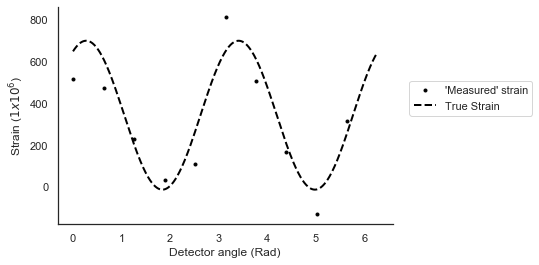

In [13]:
#changing the number of measurements to 10 
number_of_angles = 10
gamma = np.arange(0, angular_range , angular_range / number_of_angles)
h = calculate_directions(gamma)
p = calculate_stress_factors(h, E, v)
strain_sample = p[0]*true_s11  + p[1]*true_s22 + p[2]*true_s12 
simulated_strain_measurements = strain_sample + np.random.normal(scale = 0.0001 ,size = strain_sample.size)

f, ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label = '\'Measured\' strain', ms = 3, color = 'k')
ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()


C:\Users\Farah\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     20.60
Date:                Sun, 19 Jul 2020   Prob (F-statistic):            0.00117
Time:                        18:37:40   Log-Likelihood:                 77.840
No. Observations:                  10   AIC:                            -149.7
Df Residuals:                       7   BIC:                            -148.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           138.1629     14.191      9.736      0.0

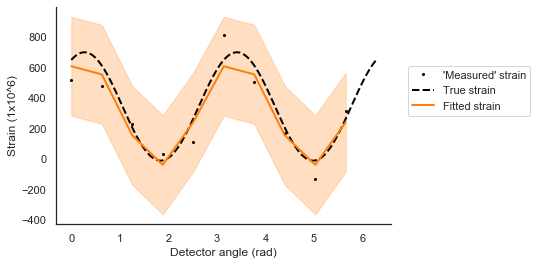

In [14]:
small_model = sm.OLS(simulated_strain_measurements,p.T)
#model = sm.OLS(measurements,p.T)
small_fit_outcome = small_model.fit()
#fit_outcome = model.fit()
small_strain_fit= small_fit_outcome.predict()
#fitted_strain = fit_outcome.predict()
small_prstd, small_iv_l, small_iv_u = wls_prediction_std(small_fit_outcome)

print(small_fit_outcome.summary())

f,ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label='\'Measured\' strain',ms=2,color='k')
ax.plot(true_strain_gamma, true_strain*1e6, label='True strain', lw=2.,ls='--',color='k')
ax.plot(gamma, small_strain_fit*1e6,label='Fitted strain',lw=2,color='C1')
ax.fill_between(gamma,small_iv_l*1e6,small_iv_u*1e6,color='C1',alpha=0.25)
ax.set_xlabel('Detector angle (rad)')
ax.set_ylabel('Strain (1x10^6)')
ax.legend(loc=(1.05,0.5))
seaborn.despine()

Again, the least correct stress tensor is $\sigma_{12}$. The standard deviations are also much higher, which is expected given the smaller dataset. Attempting to fit the same dataset using Bayesian returns the following results:

In [15]:
with pm.Model() as small_sample_pymc_model: 
    stress = pm.Normal('stress', 100, sigma = 300, shape = 3)
    sigma = pm.HalfNormal('sigma', sigma = 0.1)
    
    likelihood = pm.Normal('strain', 
                            mu = p[0]*stress[0]+p[1]*stress[1]+p[2]*stress[2],
                            sigma = sigma,
                            observed = simulated_strain_measurements)
    
    trace = pm.sample(draws = 1000, tune = 1000, cores = 2)
    # sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, stress]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 120 seconds.


In [16]:
pm.summary(trace)

C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
stress[0],137.192,19.627,98.247,172.474,0.559,0.395,1235.0,1235.0,1335.0,805.0,1.0
stress[1],39.187,18.427,5.572,74.301,0.473,0.352,1517.0,1368.0,1566.0,1028.0,1.0
stress[2],26.987,11.783,5.086,49.885,0.323,0.239,1331.0,1216.0,1497.0,1027.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.000,791.0,791.0,787.0,918.0,1.0


Plotting the strain fits for both models: 

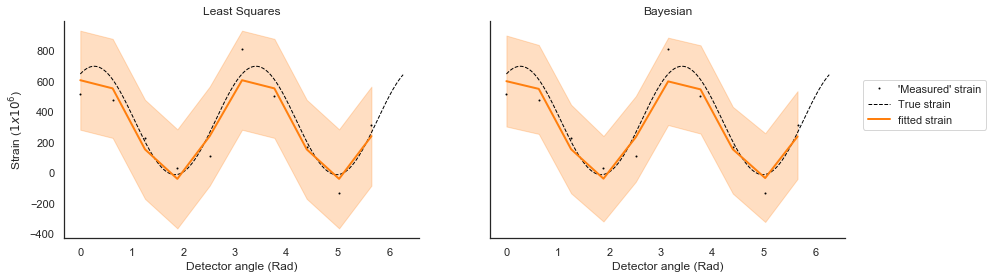

In [17]:
pymc_fitted_strain = posterior_predictive['strain'].mean(axis = 0)
lower, upper = st.mstats.mquantiles(posterior_predictive['strain'], [0.05, 0.95], axis = 0)

f, axs = plt.subplots(1, 2, figsize = (14,4), sharey = True)

for ax in axs:
    ax.plot(gamma, simulated_strain_measurements*1e6, '.', label = '\'Measured\' strain', ms = 2, color = 'k')
    ax.plot(true_strain_gamma, true_strain*1e6, '--', label = 'True strain', lw = 1., color = 'k')
    
    ax.set_xlabel('Detector angle (Rad)')

axs[0].plot(gamma,small_strain_fit*1e6,label='fitted strain',lw=2,color='C1')
axs[0].fill_between(gamma,small_iv_l*1e6,small_iv_u*1e6,color='C1',alpha=0.25)

#axs[1].errorbar(gamma,mean*1e6,std*1e6,fmt='_',ms=5,color='C2',label='predictions',alpha=0.5)

axs[1].plot(gamma,pymc_fitted_strain*1e6,label='fitted strain',lw=2,color='C1')
axs[1].fill_between(gamma,lower*1e6,upper*1e6,color='C1',alpha=0.25)

axs[0].set_title('Least Squares')
axs[0].set_ylabel('Strain ($1x10^6$)')
axs[1].set_title('Bayesian')
axs[1].legend(loc=(1.05, 0.5))
seaborn.despine()

The fits appear to be identical, again this can be attributed to the Normal disribution of errors. Comparing the fit quality: 

| Stress Tensor | OLS Stress(MPa), Std Dev | OLS Stress - True Stress (% of true stress) | Bayesian Stress(MPa) | Bayesian Stress - True Stress(% of true stress)) |
|:-------------:|:------------------------:|:-------------------------------------------:|:--------------------:|:------------------------------------------------:|
| $\sigma_{11}$ |          152.46          |                     1.64                    |        152.23        |                       1.48                       |
| $\sigma_{22}$ |           57.96          |                    15.92                    |         58.99        |                       17.98                      |
| $\sigma_{12}$ |           31.20          |                     4.00                    |         31.39        |                       4.63                       |



* Both models overestimate the stress for all stress tensor components, despite a dataset where the strain is underpredicted in many of the points. This overprediction may represent a flaw in the model. 
* The least correct stress prediction is that for $\sigma_{22}$.
* $\sigma_{11}$ and $\sigma_{12}$ predictions appear unaffected by the smaller sample size,as indicated by similar deviation from the true value as in the case of 24 datapoints, whereas the $\sigma_{22}$ varies from the true value by more than 15% in for both fitting methods. 
* In this case there is a small difference in the quality of fit, Bayesian being less accurate for $\sigma_{22}$ and $\sigma_{12}$ and OLS is more accurate for $\sigma_{22}$


### II. Noise: Larger but Normally distributed errors

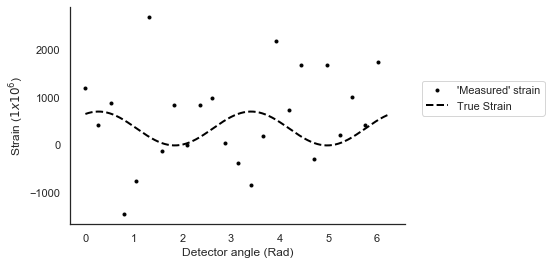

In [18]:
#changing the number of measurements back to 24
number_of_angles = 24
gamma = np.arange(0, angular_range , angular_range / number_of_angles)
h = calculate_directions(gamma)
p = calculate_stress_factors(h, E, v)
strain_sample = p[0]*true_s11  + p[1]*true_s22 + p[2]*true_s12 

#changing the 'scale' from 0.001 to 0.001 to create larger errors. 
simulated_strain_measurements = strain_sample + np.random.normal(scale = 0.001 ,size = strain_sample.size)

f, ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label = '\'Measured\' strain', ms = 3, color = 'k')
ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()


In [19]:
noisy_model = sm.OLS(simulated_strain_measurements,p.T)
#model = sm.OLS(measurements,p.T)
noisy_fit_outcome = noisy_model.fit()
#fit_outcome = model.fit()
noisy_strain_fit= noisy_fit_outcome.predict()
#fitted_strain = fit_outcome.predict()
noisy_prstd, noisy_iv_l, noisy_iv_u = wls_prediction_std(noisy_fit_outcome)

print(noisy_fit_outcome.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.3564
Date:                Sun, 19 Jul 2020   Prob (F-statistic):              0.704
Time:                        18:39:58   Log-Likelihood:                 132.67
No. Observations:                  24   AIC:                            -259.3
Df Residuals:                      21   BIC:                            -255.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           135.1458     78.195      1.728      0.0

The fit is quite poor, with standard deviations ranging from 43 to 70 MPa and stress tensor components that are far from the true values. Bayesian yields the following: 

In [20]:
with pm.Model() as small_sample_pymc_model: 
    stress = pm.Normal('stress', 100, sigma = 300, shape = 3)
    sigma = pm.HalfNormal('sigma', sigma = 0.1)
    
    likelihood = pm.Normal('strain', 
                            mu = p[0]*stress[0]+p[1]*stress[1]+p[2]*stress[2],
                            sigma = sigma,
                            observed = simulated_strain_measurements)
    
    trace = pm.sample(draws = 1000, tune = 1000, cores = 2)
    # sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, stress]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 133 seconds.


In [21]:
pm.summary(trace)

C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
stress[0],130.632,80.601,-13.760,282.548,1.566,1.226,2649.0,2160.0,2653.0,1527.0,1.0
stress[1],192.553,79.017,53.983,346.128,1.679,1.195,2215.0,2188.0,2215.0,1282.0,1.0
stress[2],-20.606,50.427,-115.899,73.046,1.175,0.972,1842.0,1346.0,1816.0,1441.0,1.0
sigma,0.001,0.000,0.001,0.001,0.000,0.000,1687.0,1617.0,1745.0,1317.0,1.0


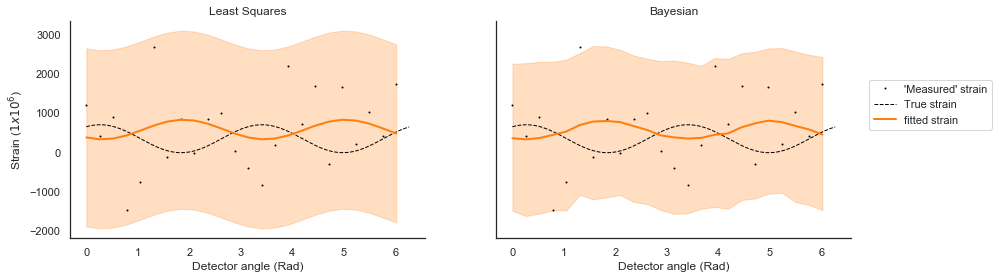

In [22]:
pymc_fitted_strain = posterior_predictive['strain'].mean(axis = 0)
lower, upper = st.mstats.mquantiles(posterior_predictive['strain'], [0.05, 0.95], axis = 0)

f, axs = plt.subplots(1, 2, figsize = (14,4), sharey = True)

for ax in axs:
    ax.plot(gamma, simulated_strain_measurements*1e6, '.', label = '\'Measured\' strain', ms = 2, color = 'k')
    ax.plot(true_strain_gamma, true_strain*1e6, '--', label = 'True strain', lw = 1., color = 'k')
    
    ax.set_xlabel('Detector angle (Rad)')

axs[0].plot(gamma,noisy_strain_fit*1e6,label='fitted strain',lw=2,color='C1')
axs[0].fill_between(gamma,noisy_iv_l*1e6,noisy_iv_u*1e6,color='C1',alpha=0.25)

#axs[1].errorbar(gamma,mean*1e6,std*1e6,fmt='_',ms=5,color='C2',label='predictions',alpha=0.5)

axs[1].plot(gamma,pymc_fitted_strain*1e6,label='fitted strain',lw=2,color='C1')
axs[1].fill_between(gamma,lower*1e6,upper*1e6,color='C1',alpha=0.25)

axs[0].set_title('Least Squares')
axs[0].set_ylabel('Strain ($1x10^6$)')
axs[1].set_title('Bayesian')
axs[1].legend(loc=(1.05, 0.5))
seaborn.despine()

Again, the Bayesian result is almost identical to OLS, failing to provide a fit close to the true distribution. 

| Stress Tensor | OLS Stress(MPa), Std Dev | OLS Stress - True Stress (% of true stress) | Bayesian Stress(MPa) | Bayesian Stress - True Stress(% of true stress)) |
|:-------------:|:------------------------:|:-------------------------------------------:|:--------------------:|:------------------------------------------------:|
| $\sigma_{11}$ |          277.77          |                    85.18                    |        268.19        |                       78.79                      |
| $\sigma_{22}$ |          -30.77          |                   -161.54                   |        -25.05        |                      -150.10                     |
| $\sigma_{12}$ |           49.76          |                    65.87                    |         49.17        |                       63.9                       |



### III. Extreme Outliers

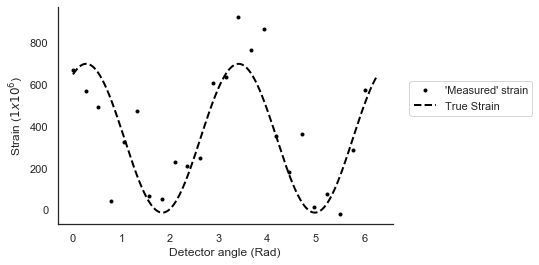

In [36]:
number_of_angles = 24
gamma = np.arange(0, angular_range , angular_range / number_of_angles)
h = calculate_directions(gamma)
p = calculate_stress_factors(h, E, v)
strain_sample = p[0]*true_s11  + p[1]*true_s22 + p[2]*true_s12 
df = 3
#the smaller df is, the noisier the distribution. 100 = Normal distribution
simulated_strain_measurements = strain_sample + 0.0001*np.random.standard_t(df, size = strain_sample.size)

# look up standard _ t distribution and make a note about it. 
f, ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label = '\'Measured\' strain', ms = 3, color = 'k')
ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()

In [37]:
standard_t_model = sm.OLS(simulated_strain_measurements,p.T)
#model = sm.OLS(measurements,p.T)
standard_t_fit_outcome = standard_t_model.fit()
#fit_outcome = model.fit()
standard_t_strain_fit= standard_t_fit_outcome.predict()
#fitted_strain = fit_outcome.predict()
standard_t_prstd, standard_t_iv_l, standard_t_iv_u = wls_prediction_std(standard_t_fit_outcome)

print(standard_t_fit_outcome.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     16.80
Date:                Sun, 19 Jul 2020   Prob (F-statistic):           4.39e-05
Time:                        19:12:58   Log-Likelihood:                 174.32
No. Observations:                  24   AIC:                            -342.6
Df Residuals:                      21   BIC:                            -339.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           150.0054     13.791     10.877      0.0

OLS is heavily impacted by the outliers. 

In [38]:
with pm.Model() as small_sample_pymc_model: 
    stress = pm.Normal('stress', 100, sigma = 300, shape = 3)
    sigma = pm.HalfNormal('sigma', sigma = 0.1)
    
    likelihood = pm.Normal('strain', 
                            mu = p[0]*stress[0]+p[1]*stress[1]+p[2]*stress[2],
                            sigma = sigma,
                            observed = simulated_strain_measurements)
    
    trace = pm.sample(draws = 1000, tune = 1000, cores = 2)
    # sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, stress]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 121 seconds.


In [39]:
pm.summary(trace)

C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
stress[0],149.750,14.848,118.220,175.644,0.328,0.232,2054.0,2054.0,2071.0,1542.0,1.0
stress[1],69.247,14.442,41.963,95.796,0.334,0.246,1867.0,1728.0,1910.0,1422.0,1.0
stress[2],28.855,9.188,12.082,45.935,0.193,0.140,2273.0,2163.0,2266.0,1577.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.000,2010.0,1969.0,2007.0,1411.0,1.0


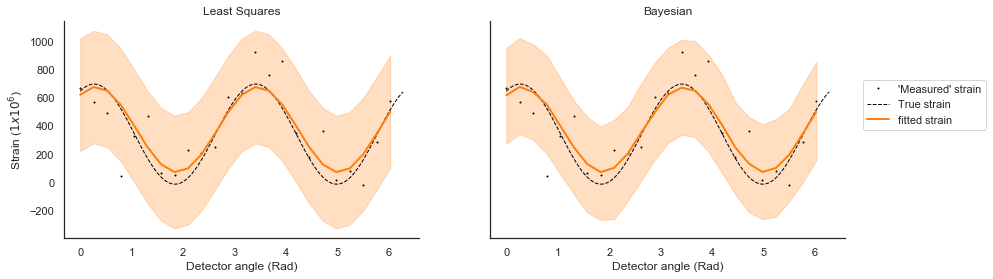

In [40]:
pymc_fitted_strain = posterior_predictive['strain'].mean(axis = 0)
lower, upper = st.mstats.mquantiles(posterior_predictive['strain'], [0.05, 0.95], axis = 0)

f, axs = plt.subplots(1, 2, figsize = (14,4), sharey = True)

for ax in axs:
    ax.plot(gamma, simulated_strain_measurements*1e6, '.', label = '\'Measured\' strain', ms = 2, color = 'k')
    ax.plot(true_strain_gamma, true_strain*1e6, '--', label = 'True strain', lw = 1., color = 'k')
    
    ax.set_xlabel('Detector angle (Rad)')

axs[0].plot(gamma,standard_t_strain_fit*1e6,label='fitted strain',lw=2,color='C1')
axs[0].fill_between(gamma,standard_t_iv_l*1e6,standard_t_iv_u*1e6,color='C1',alpha=0.25)

#axs[1].errorbar(gamma,mean*1e6,std*1e6,fmt='_',ms=5,color='C2',label='predictions',alpha=0.5)

axs[1].plot(gamma,pymc_fitted_strain*1e6,label='fitted strain',lw=2,color='C1')
axs[1].fill_between(gamma,lower*1e6,upper*1e6,color='C1',alpha=0.25)

axs[0].set_title('Least Squares')
axs[0].set_ylabel('Strain ($1x10^6$)')
axs[1].set_title('Bayesian')
axs[1].legend(loc=(1.05, 0.5))
seaborn.despine()

Although the fit is almost identical. More runs are necessary to know a) whether bayesian (even with a less restrictive prior) is better at excluding outliers, and b) whether this exclusion improves the quality of the fit. 

### IV. A combination of I, II and III

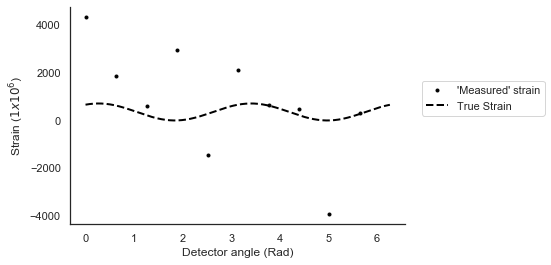

In [47]:
number_of_angles = 10
gamma = np.arange(0, angular_range , angular_range / number_of_angles)
h = calculate_directions(gamma)
p = calculate_stress_factors(h, E, v)
strain_sample = p[0]*true_s11  + p[1]*true_s22 + p[2]*true_s12 
df = 3
simulated_strain_measurements = strain_sample + 0.001*np.random.standard_t(df, size = strain_sample.size)
f, ax = plt.subplots()
ax.plot(gamma, simulated_strain_measurements*1e6, 'o', label = '\'Measured\' strain', ms = 3, color = 'k')
ax.plot(true_strain_gamma, true_strain*1e6, label = 'True Strain', lw = 2., ls = '--', color = 'k')
ax.set_xlabel('Detector angle (Rad)')
ax.set_ylabel('Strain ($1 x 10^6$) ')
ax.legend(loc = (1.05, 0.5))
seaborn.despine()

In [48]:
combination_model = sm.OLS(simulated_strain_measurements,p.T)
#model = sm.OLS(measurements,p.T)
combination_fit_outcome = combination_model.fit()
#fit_outcome = model.fit()
combination_strain_fit= combination_fit_outcome.predict()
#fitted_strain = fit_outcome.predict()
combination_prstd, combination_iv_l, combination_iv_u = wls_prediction_std(combination_fit_outcome)

print(combination_fit_outcome.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.378
Date:                Sun, 19 Jul 2020   Prob (F-statistic):              0.313
Time:                        19:26:20   Log-Likelihood:                 48.724
No. Observations:                  10   AIC:                            -91.45
Df Residuals:                       7   BIC:                            -90.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           449.7106    260.911      1.724      0.1

C:\Users\Farah\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [49]:
with pm.Model() as small_sample_pymc_model: 
    stress = pm.Normal('stress', 100, sigma = 300, shape = 3)
    sigma = pm.HalfNormal('sigma', sigma = 0.1)
    
    likelihood = pm.Normal('strain', 
                            mu = p[0]*stress[0]+p[1]*stress[1]+p[2]*stress[2],
                            sigma = sigma,
                            observed = simulated_strain_measurements)
    
    trace = pm.sample(draws = 1000, tune = 1000, cores = 2)
    # sample data as though prior is correct
    prior = pm.sample_prior_predictive()
    #samples data with corrected prior distribution
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, stress]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 112 seconds.


In [50]:
pm.summary(trace)

C:\Users\Farah\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
stress[0],302.362,203.845,-77.143,686.979,4.510,3.450,2043.0,1746.0,2061.0,1414.0,1.0
stress[1],28.340,204.602,-376.251,391.111,5.073,4.318,1627.0,1123.0,1623.0,1393.0,1.0
stress[2],138.054,151.736,-161.276,410.356,3.288,3.088,2130.0,1208.0,2141.0,1210.0,1.0
sigma,0.002,0.001,0.001,0.004,0.000,0.000,1593.0,1525.0,1621.0,1240.0,1.0


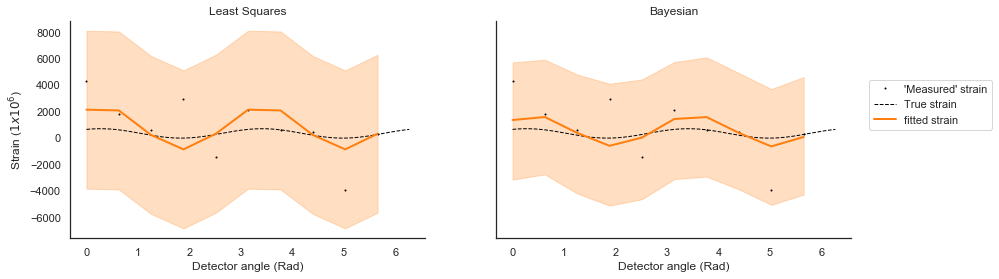

In [51]:
pymc_fitted_strain = posterior_predictive['strain'].mean(axis = 0)
lower, upper = st.mstats.mquantiles(posterior_predictive['strain'], [0.05, 0.95], axis = 0)


f,axs = plt.subplots(1,3,figsize=(10,3),sharex=True)

for ax,stress in zip(axs,['s11','s22','s12']):
    ax.plot(true['location'],true[stress],marker='s',ms=6,ls='none')
    ax.errorbar(lsq['location']-0.1,lsq[stress],yerr=lsq['{}_unc'.format(stress)],marker='o',ms=6,ls='none')
    ax.errorbar(bayes['location']+0.1,bayes[stress],yerr=bayes['{}_unc'.format(stress)],marker='o',ms=6,ls='none')
    ax.set_xlabel('location')
    ax.set_ylabel('Stress (MPa) [{}]'.format(stress))
ax.legend(['True','Lsq','Bayesian'],loc=(1.05,0.5))

seaborn.despine(offset=5)
f.tight_layout()